In [1]:
import numpy as np
from scipy.signal import correlate2d
from PIL import Image
import cv2
import glob
import os
import matplotlib.pyplot as plt

# 调节阈值（未使用，但保留）
threshold_constant = 1.4

# 时间间隔（未使用，但保留）
time_interval = 0.1

# 文件夹路径
image_folder = "C:\\Users\\PC\\Desktop\\final year project\\pictures\\20250119"

# 加载文件夹中的所有图片（假设文件夹中只有图片文件）
image_files = glob.glob(os.path.join(image_folder, "*.png"))
image_files = image_files[:50]  # 只处理前 50 张图片

# 检查是否有图片
if not image_files:
    raise ValueError("No images found in the folder.")

# 存储选中的点坐标
rois = []

# 缩放比例
scale = 0.5  # 图像缩小到 50%

# OpenCV 鼠标回调函数
def select_rois(event, x, y, flags, param):
    """
    OpenCV 鼠标回调函数，用于选择矩形区域的坐标。
    """
    global rois, drawing, ix, iy

    if event == cv2.EVENT_LBUTTONDOWN:  # 鼠标左键按下
        drawing = True
        ix, iy = x, y  # 记录起始点

    elif event == cv2.EVENT_LBUTTONUP:  # 鼠标左键释放
        drawing = False
        # 将坐标转换为原始图像的坐标
        x_original = int(x / scale)
        y_original = int(y / scale)
        ix_original = int(ix / scale)
        iy_original = int(iy / scale)
        # 记录 ROI 的坐标 (y_min, y_max, x_min, x_max)
        rois.append((min(iy_original, y_original), max(iy_original, y_original), 
                     min(ix_original, x_original), max(ix_original, x_original)))
        print(f"ROI selected: {rois[-1]}")
        # 在原始图像上绘制矩形
        cv2.rectangle(original_image, (ix_original, iy_original), (x_original, y_original), (0, 255, 0), 2)
        # 更新显示图像
        resized_image = cv2.resize(original_image, (0, 0), fx=scale, fy=scale)
        cv2.imshow("Select ROIs", resized_image)

# Step 1: 在第一张图片上选择 ROI (2个)
print("Please draw a rectangle on the first image to select the ROI for cross-correlation.")
first_image_path = image_files[0]
first_image = Image.open(first_image_path).convert("L")  # 转换为灰度图像
first_image_array = np.array(first_image)

# 将图像转换为 OpenCV 格式（BGR）
original_image = cv2.cvtColor(first_image_array, cv2.COLOR_GRAY2BGR)

# 调整图像大小
resized_image = cv2.resize(original_image, (0, 0), fx=scale, fy=scale)

# 创建窗口并绑定鼠标回调函数
cv2.namedWindow("Select ROIs", cv2.WINDOW_NORMAL)
cv2.setMouseCallback("Select ROIs", select_rois)

# 显示图像并等待用户选择 ROI
while True:
    cv2.imshow("Select ROIs", resized_image)
    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # 按下 ESC 键退出
        break
    if key == 13:  # 按下回车键确认选择完成
        if len(rois) >= 1:  # 至少选择一个 ROI
            break
        else:
            print("Please select at least one ROI.")

cv2.destroyAllWindows()

# 检查是否选择了至少一个 ROI
if len(rois) < 1:
    raise ValueError("Please select at least one ROI.")

# 提取基准 ROI 的坐标
base_roi1 = rois[0]  # 第一个 ROI 作为基准
base_roi2 = rois[1]
# Step 2: 提取基准 ROI 的图像
base_roi_array1 = first_image_array[base_roi1[0]:base_roi1[1], base_roi1[2]:base_roi1[3]]
base_roi_array2 = first_image_array[base_roi2[0]:base_roi2[1], base_roi2[2]:base_roi2[3]]

Please draw a rectangle on the first image to select the ROI for cross-correlation.
ROI selected: (212, 442, 556, 810)
ROI selected: (592, 776, 760, 956)


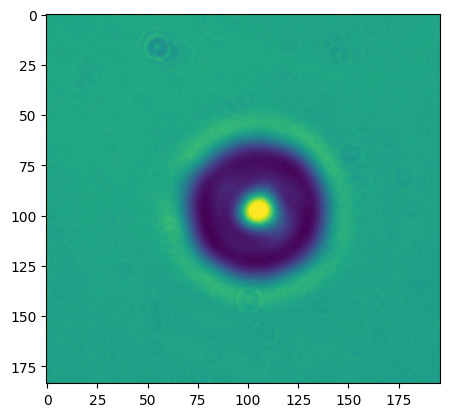

In [2]:
plt.imshow(base_roi_array2)
plt.show()

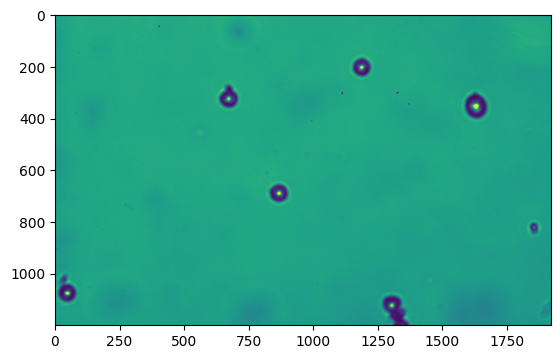

In [3]:
image = Image.open(image_files[0]).convert("L")
first_image_array=np.array(image)
plt.imshow(first_image_array)
plt.show()

In [4]:
first_image_array.shape

(1200, 1920)

In [4]:
correlation = correlate2d(base_roi_array1,base_roi_array2,mode='full')

In [5]:
correlation_normalized=correlation/np.max(correlation)

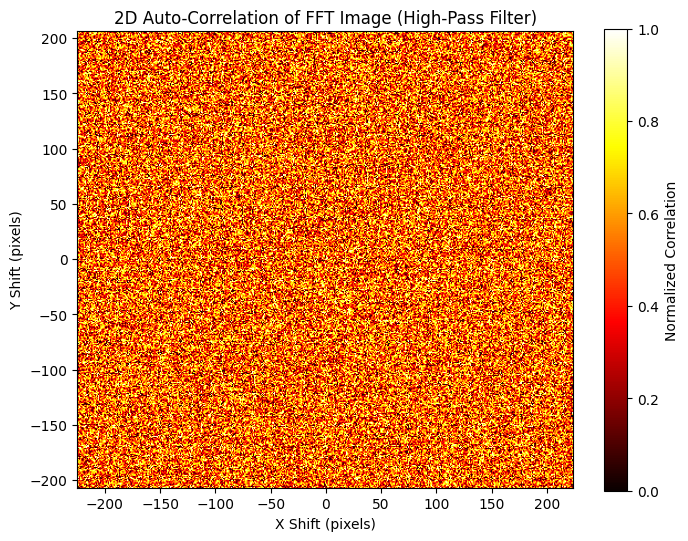

In [6]:
plt.figure(figsize=(8, 6))
plt.imshow(correlation_normalized, cmap='hot', extent=[-correlation.shape[1] // 2, correlation.shape[1] // 2,
                                                        -correlation.shape[0] // 2, correlation.shape[0] // 2])
plt.title("2D Auto-Correlation of FFT Image (High-Pass Filter)")
plt.colorbar(label="Normalized Correlation")
plt.xlabel("X Shift (pixels)")
plt.ylabel("Y Shift (pixels)")
plt.show()

In [ ]:

# Step 3: 对第一张和第二张图片进行 cross-correlation
correlation_results = []
for i, image_path in enumerate(image_files[:2]):  # 只处理前两张图片
    # 加载图片并转换为灰度图像
    image = Image.open(image_path).convert("L")
    image_array = np.array(image)

    # 计算 cross-correlation
    correlation = correlate2d(image_array, base_roi_array, mode='full')

    # 找到最大相关值的位置
    # max_corr_pos = np.unravel_index(np.argmax(correlation), correlation.shape)
    correlation_results.append(correlation)


In [ ]:

# Step 4: 绘制 cross-correlation 结果
plt.figure(figsize=(12, 6))

# 绘制第一张图片的 cross-correlation 结果
plt.subplot(1, 2, 1)
plt.imshow(correlation_results[0][0], cmap='viridis', aspect='auto')
plt.colorbar(label='Correlation Value')
plt.scatter(correlation_results[0][1][1], correlation_results[0][1][0], color='red', label='Max Correlation')
plt.title('Cross-Correlation (Image 1)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()

# 绘制第二张图片的 cross-correlation 结果
plt.subplot(1, 2, 2)
plt.imshow(correlation_results[1][0], cmap='viridis', aspect='auto')
plt.colorbar(label='Correlation Value')
plt.scatter(correlation_results[1][1][1], correlation_results[1][1][0], color='red', label='Max Correlation')
plt.title('Cross-Correlation (Image 2)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()

plt.tight_layout()
plt.show()

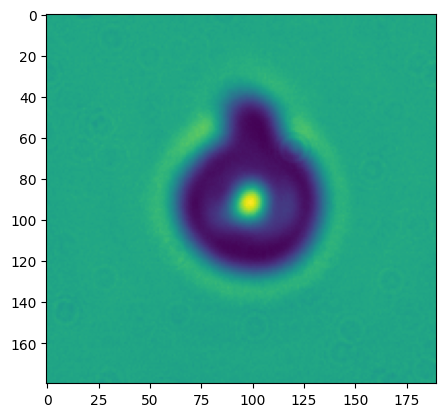

In [3]:
plt.imshow(base_roi_array)
plt.show()

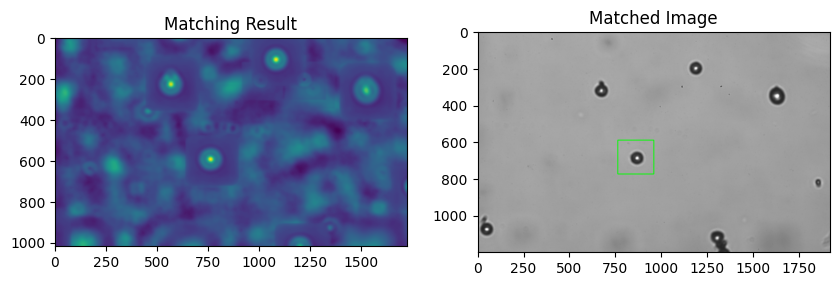

In [7]:
result = cv2.matchTemplate(first_image_array,base_roi_array2, cv2.TM_CCOEFF_NORMED)

# 找到最佳匹配位置
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
top_left = max_loc  # 归一化互相关的最大值位置

# 计算模板的右下角位置
h, w = base_roi_array2.shape
bottom_right = (top_left[0] + w, top_left[1] + h)

# 在目标图像上绘制矩形框
matched_image = cv2.cvtColor(first_image_array, cv2.COLOR_GRAY2BGR)  # 转换为彩色图像以便绘制矩形
cv2.rectangle(matched_image, top_left, bottom_right, (0, 255, 0), 3)  # 绘制绿色矩形框

# 显示匹配结果
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Matching Result')
plt.imshow(result, cmap='viridis')

plt.subplot(1, 2, 2)
plt.title('Matched Image')
plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))  # 转换为 RGB 格式显示

plt.show()

In [13]:
import numpy as np
from scipy.signal import correlate2d
from scipy.ndimage import uniform_filter

def normalized_cross_correlation(image, template):
    # Step 1: 计算模板的均值
    template_mean = np.mean(template)
    template_normalized = template - template_mean

    # Step 2: 计算图像的局部均值
    image_mean = uniform_filter(image, size=template.shape, mode='constant')

    # Step 3: 计算互相关
    numerator = correlate2d(image - image_mean, template_normalized, mode='same')

    # Step 4: 计算分母
    template_var = np.sum(template_normalized ** 2)
    image_var = correlate2d((image - image_mean) ** 2, np.ones_like(template), mode='same')
    denominator = np.sqrt(template_var * image_var)

    # Step 5: 防止除零错误
    # 设置一个很小的值（如 1e-10）作为分母的最小值
    epsilon = 1e-10
    denominator = np.maximum(denominator, epsilon)

    # Step 6: 归一化
    result = numerator / denominator

    return result

In [14]:

# 示例使用
image = first_image_array  # 输入图像
template = base_roi_array1  # 模板

# 使用自定义函数计算
result_custom = normalized_cross_correlation(image, template)


In [34]:
import numpy as np
from scipy.fft import fft2, ifft2, fftshift
from scipy.ndimage import uniform_filter

def normalized_cross_correlation_fft(image, template):
    """
    使用 FFT 加速计算归一化互相关（NCC）。
    
    参数：
        image: 输入图像（二维数组）。
        template: 模板（二维数组）。
    
    返回：
        result: 归一化互相关结果（二维数组）。
    """
    # Step 1: 计算模板的均值
    template_mean = np.mean(template)
    template_normalized = template - template_mean

    # Step 2: 计算图像的局部均值
    image_mean = uniform_filter(image, size=template.shape, mode='constant')

    # Step 3: 使用 FFT 计算互相关
    # 将图像和模板填充到相同大小（避免循环卷积）
    padded_shape = np.array(image.shape) + np.array(template.shape) - 1
    image_padded = np.pad(image - image_mean, 
                          ((0, padded_shape[0] - image.shape[0]), 
                           (0, padded_shape[1] - image.shape[1])))
    template_padded = np.pad(template_normalized, 
                             ((0, padded_shape[0] - template.shape[0]), 
                              (0, padded_shape[1] - template.shape[1])))

    # 计算 FFT
    image_fft = fft2(image_padded)
    template_fft = fft2(template_padded)
    correlation_fft = ifft2(image_fft * np.conj(template_fft)).real

    # 裁剪到原始图像大小
    correlation = correlation_fft[template.shape[0]-1:, template.shape[1]-1:][:image.shape[0], :image.shape[1]]

    # Step 4: 计算分母
    template_var = np.sum(template_normalized ** 2)
    image_var = uniform_filter((image - image_mean) ** 2, size=template.shape, mode='constant') * np.prod(template.shape)
    denominator = np.sqrt(template_var * image_var)

    # Step 5: 防止除零错误
    epsilon = 1e-10
    denominator = np.maximum(denominator, epsilon)

    # Step 6: 归一化
    result = correlation / denominator

    return result

In [35]:
# 示例使用
image = first_image_array  # 输入图像
template = base_roi_array1  # 模板

# 使用自定义函数计算
result_custom = normalized_cross_correlation_fft(image, template)

In [25]:
result_custom=result_custom/np.max(np.abs(result_custom))

In [15]:

# 使用 OpenCV 计算
import cv2
result_cv2 = cv2.matchTemplate(image.astype(np.float32), template.astype(np.float32), cv2.TM_CCOEFF_NORMED)


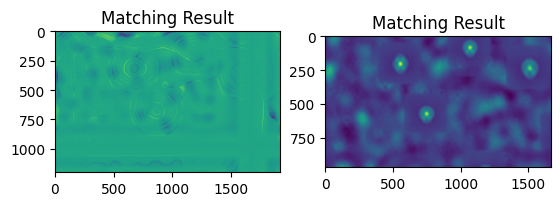

In [36]:
plt.subplot(1, 2, 1)
plt.title('Matching Result')
plt.imshow(result_custom, cmap='viridis')
plt.subplot(1, 2, 2)
plt.title('Matching Result')
plt.imshow(result_cv2, cmap='viridis')
plt.show()

In [27]:
print(result_custom)

[[ 8.79476259e-18  3.80620873e-18 -2.45462440e-18 ... -9.65070493e-17
  -1.25796470e-16 -9.35703790e-17]
 [ 6.55733405e-18 -2.67002070e-18 -7.13475527e-18 ... -1.07781066e-16
  -2.94655585e-16 -2.28063629e-16]
 [ 8.17083556e-19 -4.85086394e-18 -7.86183792e-18 ... -8.58583648e-17
  -1.33499346e-16 -2.66335395e-16]
 ...
 [ 4.60208121e-17  4.18534814e-17  1.06923501e-17 ... -3.53737410e-16
  -1.51849329e-16 -1.57667288e-16]
 [ 4.68355676e-17  3.31821958e-17  3.92143590e-17 ... -1.69846680e-16
  -2.19453591e-16 -2.26335902e-16]
 [ 3.09897044e-17  5.87513268e-17  2.81867945e-17 ... -1.45456397e-16
  -1.48698720e-16 -1.34987391e-16]]


In [34]:
import numpy as np
from PIL import Image
import cv2
import glob
import os
import matplotlib.pyplot as plt

# 调节阈值
threshold_constant = 1.4

# 时间间隔
time_interval = 0.1

# 文件夹路径
image_folder = "C:\\Users\\PC\\Desktop\\final year project\\pictures\\20250119"

# 存储所有图片的距离
output_distances = []  

# 加载文件夹中的所有图片（假设文件夹中只有图片文件）
image_files = glob.glob(os.path.join(image_folder, "*.png"))
image_files = image_files[:50]

# 检查是否有图片
if not image_files:
    raise ValueError("No images found in the folder.")

# 存储选中的点坐标
rois = []

# 缩放比例
scale = 0.5  # 图像缩小到 50%

# OpenCV 鼠标回调函数
def select_rois(event, x, y, flags, param):
    """
    OpenCV 鼠标回调函数，用于选择矩形区域的坐标。
    """
    global rois, drawing, ix, iy

    if event == cv2.EVENT_LBUTTONDOWN:  # 鼠标左键按下
        drawing = True
        ix, iy = x, y  # 记录起始点

    elif event == cv2.EVENT_LBUTTONUP:  # 鼠标左键释放
        drawing = False
        # 将坐标转换为原始图像的坐标
        x_original = int(x / scale)
        y_original = int(y / scale)
        ix_original = int(ix / scale)
        iy_original = int(iy / scale)
        # 记录 ROI 的坐标 (y_min, y_max, x_min, x_max)
        rois.append((min(iy_original, y_original), max(iy_original, y_original), 
                     min(ix_original, x_original), max(ix_original, x_original)))
        print(f"ROI selected: {rois[-1]}")
        # 在原始图像上绘制矩形
        cv2.rectangle(original_image, (ix_original, iy_original), (x_original, y_original), (0, 255, 0), 2)
        # 更新显示图像
        resized_image = cv2.resize(original_image, (0, 0), fx=scale, fy=scale)
        cv2.imshow("Select ROIs", resized_image)

# Step 1: 在第一张图片上选择 ROI
print("Please draw rectangles on the first image to select the ROIs.")
first_image_path = image_files[0]
first_image = Image.open(first_image_path).convert("L")  # 转换为灰度图像
first_image_array = np.array(first_image)

# 将图像转换为 OpenCV 格式（BGR）
original_image = cv2.cvtColor(first_image_array, cv2.COLOR_GRAY2BGR)

# 调整图像大小
resized_image = cv2.resize(original_image, (0, 0), fx=scale, fy=scale)

# 创建窗口并绑定鼠标回调函数
cv2.namedWindow("Select ROIs", cv2.WINDOW_NORMAL)
cv2.setMouseCallback("Select ROIs", select_rois)

# 显示图像并等待用户选择 ROI
while True:
    cv2.imshow("Select ROIs", resized_image)
    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # 按下 ESC 键退出
        break
    if key == 13:  # 按下回车键确认选择完成
        if len(rois) >= 2:  # 至少选择一个 template 和一个 ROI
            break
        else:
            print("Please select at least one template and one ROI.")

cv2.destroyAllWindows()

# 检查是否选择了至少两个 ROI
if len(rois) < 2:
    raise ValueError("Please select at least two ROIs.")

# Step 2: 对每个 ROI 进行模板匹配
dynamics_global_coordinates=[]
# 提取第一个 ROI 作为模板
template_roi = rois[0]

for image_path in image_files:
    image = Image.open(image_path).convert("L")  # 转换为灰度图像
    image_array = np.array(image)
    template = image_array[template_roi[0]:template_roi[1], template_roi[2]:template_roi[3]]
    global_coordinates = []  # 存储每个 ROI 的最佳匹配位置的全局坐标
    for i, roi in enumerate(rois[1:]):  # 从第二个 ROI 开始
        # 提取当前 ROI
        image_roi = image_array[roi[0]:roi[1], roi[2]:roi[3]]
        
        # 检查 ROI 是否比模板小
        if image_roi.shape[0] < template.shape[0] or image_roi.shape[1] < template.shape[1]:
            print(f"ROI {i + 1} is smaller than the template. Skipping this ROI.")
            continue  # 跳过这个 ROI
        
        # 使用 OpenCV 的 matchTemplate 进行模板匹配
        result = cv2.matchTemplate(image_roi, template, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        
        # 最佳匹配位置
        top_left = max_loc
        bottom_right = (top_left[0] + template.shape[1], top_left[1] + template.shape[0])
        
        # 将匹配位置转换到整体坐标系
        top_left_global = (top_left[0] + roi[2], top_left[1] + roi[0])
        bottom_right_global = (bottom_right[0] + roi[2], bottom_right[1] + roi[0])
        
        # 计算质心
        centroid = ((top_left_global[0] + bottom_right_global[0]) / 2, 
                    (top_left_global[1] + bottom_right_global[1]) / 2)
        
        # 将全局坐标保存到列表中
        global_coordinates.append(centroid)
    dynamics_global_coordinates.append(global_coordinates)

# Step 3: 在最后一张图像上显示 ROI 区域和匹配最佳的点
# 加载最后一张图像
last_image_path = image_files[-1]
last_image = Image.open(last_image_path).convert("L")  # 转换为灰度图像
last_image_array = np.array(last_image)

# 将图像转换为 OpenCV 格式（BGR）
output_image = cv2.cvtColor(last_image_array, cv2.COLOR_GRAY2BGR)

# 绘制 ROI 区域
for i, roi in enumerate(rois):
    # 绘制矩形框
    cv2.rectangle(output_image, (roi[2], roi[0]), (roi[3], roi[1]), (0, 255, 0), 2)  # 绿色矩形框
    # 添加 ROI 编号
    cv2.putText(output_image, f"ROI {i + 1}", (roi[2] + 10, roi[0] + 20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)  # 绿色文本

# 绘制匹配最佳的点
for i, positions in enumerate(dynamics_global_coordinates[-1]):  # 取最后一张图的匹配结果
    if positions:  # 如果存在匹配结果
        x = int(positions[0])  # 质心的 x 坐标
        y = int(positions[1])  # 质心的 y 坐标
        # 绘制红色圆点
        cv2.circle(output_image, (x, y), 5, (0, 0, 255), -1)  # 红色圆点
        # 添加匹配点编号
        cv2.putText(output_image, f"Match {i + 1}", (x + 10, y - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)  # 红色文本

# 调整图像大小以便显示
resized_output_image = cv2.resize(output_image, (0, 0), fx=scale, fy=scale)

# 显示结果
cv2.imshow("Final Image with ROIs and Matched Points", resized_output_image)
cv2.waitKey(0)  # 等待用户按键
cv2.destroyAllWindows()


Please draw rectangles on the first image to select the ROIs.
ROI selected: (252, 398, 596, 750)
ROI selected: (74, 330, 1030, 1336)
ROI selected: (218, 568, 1422, 1864)
ROI selected: (562, 854, 692, 1084)


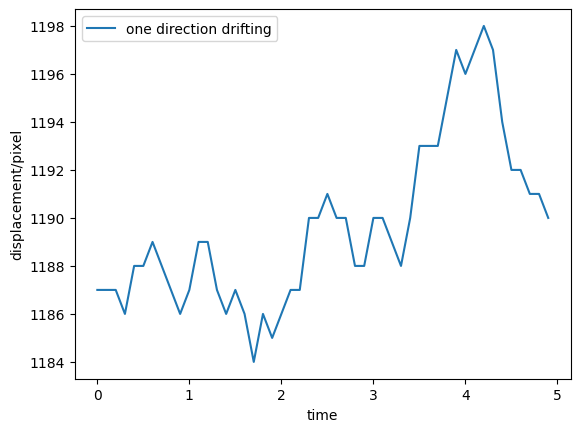

In [35]:
import numpy as np
#选择研究的微珠运动方向
direction='x'
#选择微珠序号(注意0号为第一个微珠)
bead_index=0
def switch(case):
    cases = {
    'x': 0,
    'y': 1
    }
    return cases.get(case, 'default Case')
direction = switch(direction)
one_bead_axis=np.array(dynamics_global_coordinates).T[direction][bead_index]
# 创建时间轴
time_points = np.linspace(0, time_interval * (len(image_files) - 1), len(image_files))
plt.plot(time_points,one_bead_axis,label='one direction drifting')
plt.xlabel('time')
plt.ylabel('displacement/pixel')
plt.legend()
plt.show()